# **FastKmedoids**

## **Requirements**

In [2]:
pip install FastKmedoids --upgrade


  Attempting uninstall: FastKmedoids
    Found existing installation: FastKmedoids 0.0.22
    Uninstalling FastKmedoids-0.0.22:
      Successfully uninstalled FastKmedoids-0.0.22


In [3]:
import polars as pl
from PyMachineLearning.preprocessing import encoder
from FastKmedoids.models import FastKmedoidsGG, KFoldFastKmedoidsGG, FastGG
from FastKmedoids.plots import clustering_MDS_plot
from sklearn.manifold import MDS
import seaborn as sns
sns.set_style('whitegrid')


## **Data processing**

In [4]:
madrid_houses_df = pl.read_csv('madrid_houses.csv')
columns_to_exclude = ['', 'id','sq_mt_allotment','floor', 'neighborhood', 'district'] 
madrid_houses_df = madrid_houses_df.select(pl.exclude(columns_to_exclude))

binary_cols = ['is_renewal_needed', 'has_lift', 'is_exterior', 'has_parking']
multi_cols = ['energy_certificate', 'house_type']
quant_cols = [x for x in madrid_houses_df.columns if x not in binary_cols + multi_cols]

encoder_ = encoder(method='ordinal')
encoded_arr = encoder_.fit_transform(madrid_houses_df[binary_cols + multi_cols])
cat_df = pl.DataFrame(encoded_arr)
cat_df.columns =  binary_cols + multi_cols
cat_df = cat_df.with_columns([pl.col(col).cast(pl.Int64) for col in cat_df.columns])
quant_df = madrid_houses_df[quant_cols]

madrid_houses_df = pl.concat([quant_df, cat_df], how='horizontal')

In [4]:
madrid_houses_df.head()

sq_mt_built,n_rooms,n_bathrooms,n_floors,buy_price,is_renewal_needed,has_lift,is_exterior,has_parking,energy_certificate,house_type
f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
64.0,2,1,1,85000,0,0,1,0,4,0
70.0,3,1,1,129900,1,1,1,0,0,0
94.0,2,2,1,144247,0,1,1,0,0,0
64.0,2,1,1,109900,0,1,1,0,0,0
108.0,2,2,1,260000,0,1,1,1,0,0


In [5]:
madrid_houses_df.shape

(21739, 11)

## **FastKmedoids**

In [ ]:
class FastKmedoidsGG :
    """
    Implements the Fast-K-medoids algorithm based on the Generalized Gower distance.
    """

    def __init__(self, n_clusters, method='pam', init='heuristic', max_iter=100, frac_sample_size=0.1, random_state=123,
                       p1=None, p2=None, p3=None, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                       robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20, q=1,
                       fast_VG=False, VG_sample_size=1000, VG_n_samples=5, y_type=None, verbose=True):
        """
        Constructor method.
        
        Parameters:
            n_clusters: the number of clusters.
            method: the k-medoids clustering method. Must be in ['pam', 'alternate']. PAM is the classic one, more accurate but slower.
            init: the k-medoids initialization method. Must be in ['heuristic', 'random']. Heuristic is the classic one, smarter burt slower.
            max_iter: the maximum number of iterations run by k-medodis.
            frac_sample_size: the sample size in proportional terms.
            random_state: the random seed used for the (random) sample elements.
            p1, p2, p3: number of quantitative, binary and multi-class variables in the considered data matrix, respectively. Must be a non negative integer.
            d1: name of the distance to be computed for quantitative variables. Must be an string in ['euclidean', 'minkowski', 'canberra', 'mahalanobis', 'robust_mahalanobis']. 
            d2: name of the distance to be computed for binary variables. Must be an string in ['sokal', 'jaccard'].
            d3: name of the distance to be computed for multi-class variables. Must be an string in ['matching'].
            q: the parameter that defines the Minkowski distance. Must be a positive integer.
            robust_maha_method: the method to be used for computing the robust covariance matrix. Only needed when d1 = 'robust_mahalanobis'.
            alpha : a real number in [0,1] that is used if `method` is 'trimmed' or 'winsorized'. Only needed when d1 = 'robust_mahalanobis'.
            epsilon: parameter used by the Delvin algorithm that is used when computing the robust covariance matrix. Only needed when d1 = 'robust_mahalanobis'.
            n_iters: maximum number of iterations used by the Delvin algorithm. Only needed when d1 = 'robust_mahalanobis'.
            fast_VG: whether the geometric variability estimation will be full (False) or fast (True).
            VG_sample_size: sample size to be used to make the estimation of the geometric variability.
            VG_n_samples: number of samples to be used to make the estimation of the geometric variability.
            y_type: the type of response variable. Must be in ['quantitative', 'binary', 'multiclass'].
            verbose: a boolean that controls whether certain info messages are printed or not.
        """ 
    def fit(self, X, y=None, weights=None):
        """
        Fit method: fitting the fast k-medoids algorithm to `X` (and `y` if needed).
        
        Parameters:
            X: a Pandas or Polars data-frame or a NumPy array. Represents a predictors matrix. Is required.
            y: a Pandas or Polars series or a NumPy array. Represents a response variable. Is not required.
            weights: the sample weights, if exists.
        """        
    def predict(self, X):
        """
        Predict method: predicting clusters for `X` observation by assigning them to their nearest cluster (medoid) according to Generalized Gower distance.

        Parameters:
            X: a Pandas or Polars data-frame or a NumPy array. Represents a predictors matrix. Is required.
        """

In [5]:
fast_kmedoids = FastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                                frac_sample_size=0.01, p1=5, p2=4, p3=2, 
                                d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20)
fast_kmedoids.fit(X=madrid_houses_df) 

Distance matrix size: (217, 217)


In [8]:
fast_kmedoids.labels

array([2, 1, 1, ..., 0, 0, 0], dtype=int64)

In [12]:
fast_kmedoids.labels.shape

(21739,)

In [10]:
fast_kmedoids.D_GG

array([[0.        , 2.0632824 , 2.09686916, ..., 3.20285353, 1.84380918,
        3.14611266],
       [2.0632824 , 0.        , 2.49128404, ..., 3.09380609, 3.01923008,
        1.43032853],
       [2.09686916, 2.49128404, 0.        , ..., 2.81596982, 3.36492227,
        2.98877842],
       ...,
       [3.20285353, 3.09380609, 2.81596982, ..., 0.        , 3.21190291,
        2.87445442],
       [1.84380918, 3.01923008, 3.36492227, ..., 3.21190291, 0.        ,
        2.97473498],
       [3.14611266, 1.43032853, 2.98877842, ..., 2.87445442, 2.97473498,
        0.        ]])

In [11]:
fast_kmedoids.D_GG.shape

(217, 217)

## **KFold FastKmedoids**

In [ ]:
class KFoldFastKmedoidsGG :
    """
    Implements the K-Fold Fast-K-medoids algorithm based on the Generalized Gower distance.
    """

    def __init__(self, n_clusters, method='pam', init='heuristic', max_iter=100, frac_sample_size=0.1, random_state=123,
                 p1=None, p2=None, p3=None, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                 robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20, q=1,
                 fast_VG=False, VG_sample_size=1000, VG_n_samples=5, n_splits=5, shuffle=True, kfold_random_state=123,
                 y_type=None, verbose=True) :
        """
        Constructor method.
        
        Parameters:
            n_clusters: the number of clusters.
            method: the k-medoids clustering method. Must be in ['pam', 'alternate']. PAM is the classic one, more accurate but slower.
            init: the k-medoids initialization method. Must be in ['heuristic', 'random']. Heuristic is the classic one, smarter burt slower.
            max_iter: the maximum number of iterations run by k-medodis.
            frac_sample_size: the sample size in proportional terms.
            random_state: the random seed used for the (random) sample elements.
            p1, p2, p3: number of quantitative, binary and multi-class variables in the considered data matrix, respectively. Must be a non negative integer.
            d1: name of the distance to be computed for quantitative variables. Must be an string in ['euclidean', 'minkowski', 'canberra', 'mahalanobis', 'robust_mahalanobis']. 
            d2: name of the distance to be computed for binary variables. Must be an string in ['sokal', 'jaccard'].
            d3: name of the distance to be computed for multi-class variables. Must be an string in ['matching'].
            q: the parameter that defines the Minkowski distance. Must be a positive integer.
            robust_maha_method: the method to be used for computing the robust covariance matrix. Only needed when d1 = 'robust_mahalanobis'.
            alpha : a real number in [0,1] that is used if `method` is 'trimmed' or 'winsorized'. Only needed when d1 = 'robust_mahalanobis'.
            epsilon: parameter used by the Delvin algorithm that is used when computing the robust covariance matrix. Only needed when d1 = 'robust_mahalanobis'.
            n_iters: maximum number of iterations used by the Delvin algorithm. Only needed when d1 = 'robust_mahalanobis'.
            fast_VG: whether the geometric variability estimation will be full (False) or fast (True).
            VG_sample_size: sample size to be used to make the estimation of the geometric variability.
            VG_n_samples: number of samples to be used to make the estimation of the geometric variability.
            y_type: the type of response variable. Must be in ['quantitative', 'binary', 'multiclass'].
            n_splits: number of folds to be used.
            shuffle: whether data is shuffled before applying KFold or not, must be in [True, False]. 
            kfold_random_state: the random seed for KFold if shuffle = True.
            verbose: a boolean that controls whether certain info messages are printed or not.
        """
    def fit(self, X, y=None, weights=None):
        """
        Fit method: fitting the fast k-medoids algorithm to `X` (and `y` if needed).
        
        Parameters:
            X: a Pandas or Polars data-frame or a NumPy array. Represents a predictors matrix. Is required.
            y: a Pandas or Polars series or a NumPy array. Represents a response variable. Is not required.
            weights: the sample weights, if exists.
        """
    def predict(self, X):
        """
        Predict method: predicting clusters for `X` observation by assigning them to their nearest cluster (medoid) according to Generalized Gower distance.

        Parameters:
            X: a Pandas or Polars data-frame or a NumPy array. Represents a predictors matrix. Is required.
        """

In [6]:
kfold_fast_kmedoids = KFoldFastKmedoidsGG(n_clusters=3, method='pam', init='heuristic', max_iter=100, random_state=123,
                                          frac_sample_size=0.1, n_splits=10, shuffle=True, kfold_random_state=123,
                                          p1=5, p2=4, p3=2, d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                          robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20,
                                          fast_VG=False, VG_sample_size=1000, VG_n_samples=5)
kfold_fast_kmedoids.fit(X=madrid_houses_df) 

Num.Folds: 10. Fold size: 2173.
Distance matrix size: 218 (0.1*2173) 
Clustering Fold 0
Distance matrix size: (217, 217)
Clustering Fold 1
Distance matrix size: (217, 217)
Clustering Fold 2
Distance matrix size: (217, 217)
Clustering Fold 3
Distance matrix size: (217, 217)
Clustering Fold 4
Distance matrix size: (217, 217)
Clustering Fold 5
Distance matrix size: (217, 217)
Clustering Fold 6
Distance matrix size: (217, 217)
Clustering Fold 7
Distance matrix size: (217, 217)
Clustering Fold 8
Distance matrix size: (217, 217)
Clustering Fold 9
Distance matrix size: (217, 217)
X_medoids size: (30, 11)
Distance matrix size: (24, 24)


In [7]:
kfold_fast_kmedoids.labels

array([0, 1, 1, ..., 1, 1, 1])

In [8]:
kfold_fast_kmedoids.labels.shape

(21739,)

## **Clustering Visualization**

In [ ]:
def clustering_MDS_plot(X_mds, y_pred, y_true=None, title='', accuracy=None, time=None, figsize=(8, 5), n_rows=2, bbox_to_anchor=(1.2, 1), 
                        title_size=13, title_weight='bold', points_size=45, title_height=0.98, subtitles_size=12, subtitle_weight='bold',
                        hspace=0.8, wspace=0.4, save=False, file_name=None, legend_size=9):

    """
    Displays the MDS plot for one or several clustering configurations, 
    differentiating the cluster labels and the real groups, if they are known.

    Parameters (inputs)
    ----------
    X_mds: a numpy array with the MDS matrix for the distance matrix used in the considered clustering configuration.
    y_pred: a numpy array with the predictions of the response for the single case or a dictionary with those arrays as items for the multiple case.
    y_true: a numpy array with the true values of the response. Not required.
    title: the title of the plot. 
    accuracy: the accuracy of the clustering algorithm, if computed. Not required.
    time: the execution time of the clustering algorithm, if computed. Not required.
    figsize: the size of the plot.
    bbox_to_anchor: the size of the legend box.
    title_fontsize: the size of the font of the title.
    title_weight: the weight of the title.
    points_size: the size of the points of the plot.
    title_height: the height of the tile of the plot.
    subtitles_size: subtitles sizes, for the multiple case.
    subtitle_weight: subtitle weight, for the multiple case.
    hspace: height space between the subplots, for the multiple case.
    wspace: width space between the subplots, for the multiple case.
    legend_size: size of the legend.
    save: whether the plot is saved or not.
    file_name: file name if the plot is saved.

    Returns (outputs)
    -------
    The described plot.
    """

### **Single clustering method**

In [4]:
fast_kmedoids = FastKmedoidsGG(n_clusters=2, method='pam', init='heuristic', max_iter=100, random_state=123,
                                frac_sample_size=0.03, p1=5, p2=4, p3=2, 
                                d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20)
fast_kmedoids.fit(X=madrid_houses_df) 

Distance matrix size: (652, 652)


In [5]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123) 
X_mds = mds.fit_transform(fast_kmedoids.D_GG)

c:\Users\fscielzo\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


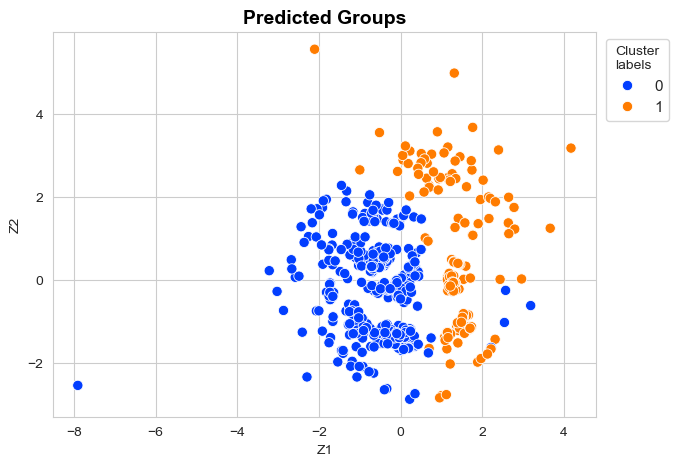

Number of data points plotted: 652


In [8]:
clustering_MDS_plot(X_mds=X_mds, y_pred=fast_kmedoids.labels[fast_kmedoids.sample_index], 
                    y_true=None, title='Predicted Groups', title_size=14, title_height=1, 
                    accuracy=None, time=None, points_size=55, legend_size=11,
                    figsize=(7,5), bbox_to_anchor=(1.15, 1))

print(f'Number of data points plotted: {len(fast_kmedoids.D_GG)}')

### **Multiple clustering method**

In [5]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=123) 

fastGG = FastGG(frac_sample_size=0.03, random_state=123, p1=5, p2=4, p3=2, 
                 d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                 robust_maha_method='trimmed', alpha=0.05)

fastGG.compute(madrid_houses_df)

X_mds = mds.fit_transform(fastGG.D_GG)

Distance matrix size: (652, 652)


c:\Users\fscielzo\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


In [6]:
fast_kmedoids_RM = FastKmedoidsGG(n_clusters=2, method='pam', init='heuristic', max_iter=100, random_state=123,
                                frac_sample_size=0.03, p1=5, p2=4, p3=2, 
                                d1='robust_mahalanobis', d2='jaccard', d3='matching', 
                                robust_maha_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20)
fast_kmedoids_RM.fit(X=madrid_houses_df) 

Distance matrix size: (652, 652)


In [7]:
fast_kmedoids_euclidean = FastKmedoidsGG(n_clusters=2, method='pam', init='heuristic', max_iter=100, random_state=123,
                                frac_sample_size=0.03, p1=5, p2=4, p3=2, 
                                d1='euclidean', d2='sokal', d3='matching')
fast_kmedoids_euclidean.fit(X=madrid_houses_df) 

Distance matrix size: (652, 652)


In [8]:
fast_kmedoids_canberra = FastKmedoidsGG(n_clusters=2, method='pam', init='heuristic', max_iter=100, random_state=123,
                                frac_sample_size=0.03, p1=5, p2=4, p3=2, 
                                d1='canberra', d2='jaccard', d3='matching')
fast_kmedoids_canberra.fit(X=madrid_houses_df) 

Distance matrix size: (652, 652)


In [9]:
y_pred = {'Fast KMedoids RobustMaha': fast_kmedoids_RM.labels[fastGG.sample_index],
          'Fast KMedoids Euclidean': fast_kmedoids_euclidean.labels[fastGG.sample_index],
          'Fast KMedoids Canberra': fast_kmedoids_canberra.labels[fastGG.sample_index]}

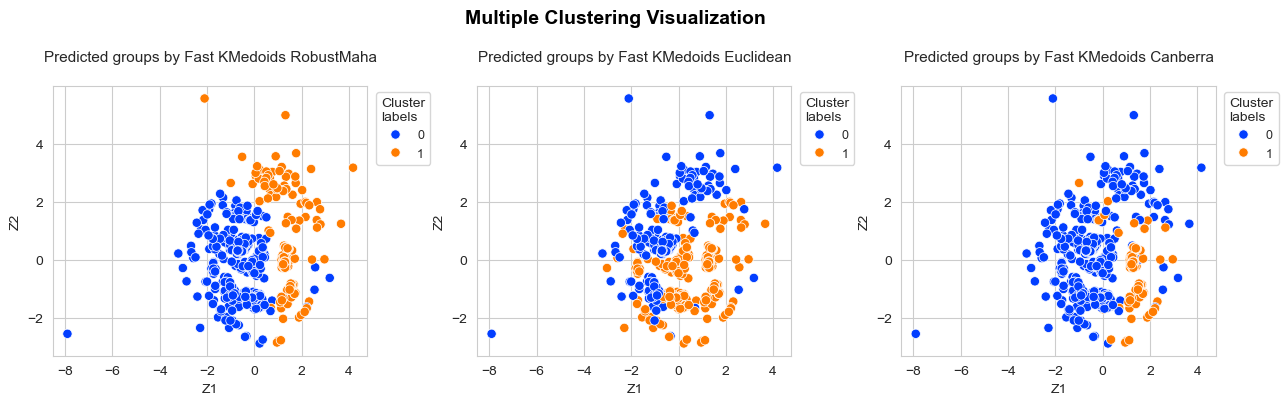

In [27]:
clustering_MDS_plot(X_mds=X_mds, y_pred=y_pred, y_true=None, title='Multiple Clustering Visualization', accuracy=None, time=None, 
                    figsize=(15, 3.5), n_rows=1, bbox_to_anchor=(1.22, 1), 
                    title_size=14, title_weight='bold', points_size=45, title_height=1.1, 
                    subtitles_size=13, subtitle_weight='bold',
                    hspace=0.8, wspace=0.35, save=False, file_name=None, legend_size=9)
